# Probabilistic PCA

This tutorial is ported from the Edward tutorial at http://edwardlib.org/tutorials/probabilistic-pca

Probabilistic principal components analysis (PCA) is a
dimensionality reduction technique that
analyzes data via a lower dimensional latent space
(Tipping & Bishop, 1999). It is often
used when there are missing values in the data or for multidimensional
scaling.

We demonstrate with an example in Turing

## Data

We use simulated data. We'll talk about the individual variables and
what they stand for in the next section. For this example, each data
point is 2-dimensional, $\mathbf{x}_n\in\mathbb{R}^2$.

In [1]:
using Distributions, StatsPlots, Random

# Set a random seed.
Random.seed!(3)


function build_toy_dataset(N, D, K, sigma=1)
    
    x_train = Array{Real}(undef, D, N)
    w = rand(Normal(0.0, 2.0), D, K)
    z = rand(Normal(0.0, 1.0), K, N)
    mean = w*z
     
    for d in 1:D, n in 1:N
        x_train[d, n] = rand(Normal(mean[d, n], sigma))
    end
    
    print("True principal axes:")
    print(w)
    
    return x_train
end


N = 50  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

x_train = build_toy_dataset(N, D, K)

True principal axes:[2.38311; -5.03947]

2×50 Array{Real,2}:
  4.52267  -3.19756  0.492527  -2.20815  …   0.779374  -2.75369  0.677037
 -9.98225   6.62618  2.32645    7.14519     -0.715196   3.29186  1.22014 

We visualize the data set.

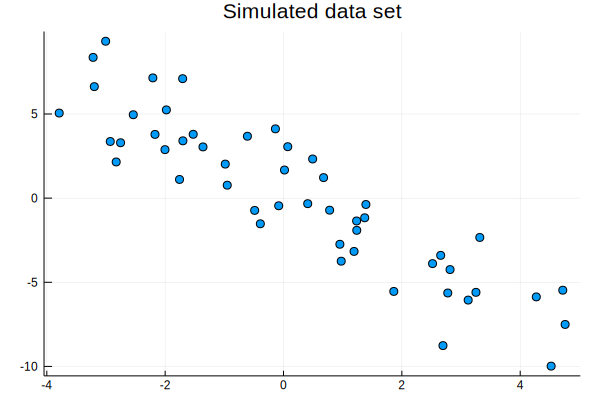

In [2]:
# Visualization.
scatter(x_train[1,:], x_train[2,:], legend = false, title = "Simulated data set")

## Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^T + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we fix $\sigma=2.0$, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

In [3]:
using Turing, MCMCChains

In [4]:
# Probabilistic Principal Component Analysis
@model PPCA(x) = begin
    
    D, N = size(x)
    
    K = 1
    
    # Set principal axis prior
    w = Matrix{Real}(undef, D, K)   
    for d in 1:D, k in 1:K
        w[d,k] ~ Normal(0, 2)
    end
    
    # Set latent variable prior
    z = Matrix{Real}(undef, K, N)
    for k in 1:K, n in 1:N
        z[k,n] ~ Normal(0, 1)
    end
    
    mean = w*z
    
    # Set data prior
    for d in 1:D, n in 1:N
        x[d, n] ~ Normal(mean[d, n], 1)
    end
    
    return w
end

PPCA (generic function with 2 methods)

In [5]:
ppca_model = PPCA(x_train)

Turing.Model{Tuple{:w,:z},Tuple{:x},getfield(Main, Symbol("###inner_function#370#8")),NamedTuple{(:x,),Tuple{Array{Real,2}}},NamedTuple{(:x,),Tuple{Symbol}}}(getfield(Main, Symbol("###inner_function#370#8"))(Core.Box(getfield(Main, Symbol("###inner_function#370#8"))(#= circular reference @-2 =#))), (x = Real[4.52267 -3.19756 … -2.75369 0.677037; -9.98225 6.62618 … 3.29186 1.22014],), (x = :nothing,))

## Inference

The posterior distribution over the principal axes $\mathbf{W}$ cannot
be analytically determined. We run Hamiltonian Monte Carlo to infer $\mathbf{W}$

In [6]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1500
ϵ = 0.05
τ = 10

# Start sampling.

chain = mapreduce(c -> sample(ppca_model, HMC(iterations, ϵ, τ)),chainscat,1:3)

[HMC] Sampling...  0%  ETA: 0:47:13
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  2%  ETA: 0:03:09
  ϵ:         0.05
  α:         0.9618452578540251
4m  pre_cond:  [1.0]


[HMC] Sampling...  3%  ETA: 0:02:13
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  4%  ETA: 0:01:52
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  6%  ETA: 0:01:40
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  7%  ETA: 0:01:34
  ϵ:         0.05
  α:         0.9427044453459344
4m  pre_cond:  [1.0]


[HMC] Sampling...  9%  ETA: 0:01:28
  ϵ:         0.05
  α:         0.7467275467726179
4m  pre_cond:  [1.0]


[HMC] Sampling... 10%  ETA: 0:01:24
  ϵ:         0.05
  α:         0.9826803079368677
4m  pre_cond:  [1.0]


[HMC] Sampling... 11%  ETA: 0:01:20
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 13%  ETA: 0:01:17
  ϵ:         0.05
  α:         0.9781916159559865
4m  pre_

4m  pre_cond:  [1.0]


[HMC] Sampling... 82%  ETA: 0:00:14
  ϵ:         0.05
  α:         0.9902973666301479
4m  pre_cond:  [1.0]


[HMC] Sampling... 84%  ETA: 0:00:12
  ϵ:         0.05
  α:         0.8618508358600103
4m  pre_cond:  [1.0]


[HMC] Sampling... 85%  ETA: 0:00:11
  ϵ:         0.05
  α:         0.8915489901999099
4m  pre_cond:  [1.0]


[HMC] Sampling... 86%  ETA: 0:00:10
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 88%  ETA: 0:00:09
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 89%  ETA: 0:00:08
  ϵ:         0.05
  α:         0.9889326598008341
4m  pre_cond:  [1.0]


[HMC] Sampling... 91%  ETA: 0:00:07
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 92%  ETA: 0:00:06
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 93%  ETA: 0:00:05
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 95%  ETA: 0:00:04
  ϵ:         0.05
  α:         0.98

[HMC] Finished with
  Running time        = 75.43280599300004;
  Accept rate         = 0.966;
  #lf / sample        = 9.993333333333334;
  #evals / sample     = 66.95666666666666;
  pre-cond. metric    = [1.0].





[HMC] Sampling...100% Time: 0:01:16
[HMC] Sampling...  1%  ETA: 0:01:15
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  3%  ETA: 0:01:14
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  4%  ETA: 0:01:12
  ϵ:         0.05
  α:         0.8579593303265527
4m  pre_cond:  [1.0]


[HMC] Sampling...  5%  ETA: 0:01:11
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  7%  ETA: 0:01:11
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  8%  ETA: 0:01:11
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  9%  ETA: 0:01:09
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 11%  ETA: 0:01:09
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 12%  ETA: 0:01:08
  ϵ:         0.05
  α:         0.9520753692976008
4m  pre_cond:  [1.0]


[HMC] Sampling... 13%  ETA: 0:01:07
  ϵ:         0.05
  α:         0.956438412667734


4m  pre_cond:  [1.0]


[HMC] Sampling... 79%  ETA: 0:00:16
  ϵ:         0.05
  α:         0.9938914377626203
4m  pre_cond:  [1.0]


[HMC] Sampling... 80%  ETA: 0:00:15
  ϵ:         0.05
  α:         0.8711996994297472
4m  pre_cond:  [1.0]


[HMC] Sampling... 82%  ETA: 0:00:14
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 83%  ETA: 0:00:13
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 84%  ETA: 0:00:13
  ϵ:         0.05
  α:         0.8680542822211437
4m  pre_cond:  [1.0]


[HMC] Sampling... 85%  ETA: 0:00:12
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 87%  ETA: 0:00:11
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 88%  ETA: 0:00:10
  ϵ:         0.05
  α:         0.9894391844874397
4m  pre_cond:  [1.0]


[HMC] Sampling... 89%  ETA: 0:00:08
  ϵ:         0.05
  α:         0.9540793781059266
4m  pre_cond:  [1.0]


[HMC] Sampling... 91%  ETA: 0:00:07
  ϵ:         0.05
  

[HMC] Finished with
  Running time        = 77.62314646099983;
  Accept rate         = 0.966;
  #lf / sample        = 9.993333333333334;
  #evals / sample     = 66.95666666666666;
  pre-cond. metric    = [1.0].





[HMC] Sampling...100% Time: 0:01:18
[HMC] Sampling...  1%  ETA: 0:01:10
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  3%  ETA: 0:01:08
  ϵ:         0.05
  α:         0.973519743768668
4m  pre_cond:  [1.0]


[HMC] Sampling...  4%  ETA: 0:01:07
  ϵ:         0.05
  α:         0.9793299531234132
4m  pre_cond:  [1.0]


[HMC] Sampling...  6%  ETA: 0:01:06
  ϵ:         0.05
  α:         0.9927669831116701
4m  pre_cond:  [1.0]


[HMC] Sampling...  7%  ETA: 0:01:06
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling...  9%  ETA: 0:01:05
  ϵ:         0.05
  α:         0.8731415040709402
4m  pre_cond:  [1.0]


[HMC] Sampling... 10%  ETA: 0:01:04
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 12%  ETA: 0:01:03
  ϵ:         0.05
  α:         0.8831995214454387
4m  pre_cond:  [1.0]


[HMC] Sampling... 13%  ETA: 0:01:02
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 14%  ETA: 0:01:02
  ϵ: 

4m  pre_cond:  [1.0]


[HMC] Sampling... 80%  ETA: 0:00:15
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 81%  ETA: 0:00:14
  ϵ:         0.05
  α:         0.9595840303335046
4m  pre_cond:  [1.0]


[HMC] Sampling... 83%  ETA: 0:00:13
  ϵ:         0.05
  α:         0.9483399616203145
4m  pre_cond:  [1.0]


[HMC] Sampling... 84%  ETA: 0:00:12
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 86%  ETA: 0:00:11
  ϵ:         0.05
  α:         0.9697053672826665
4m  pre_cond:  [1.0]


[HMC] Sampling... 87%  ETA: 0:00:10
  ϵ:         0.05
  α:         0.954137765332174
4m  pre_cond:  [1.0]


[HMC] Sampling... 88%  ETA: 0:00:09
  ϵ:         0.05
  α:         0.9640098583096097
4m  pre_cond:  [1.0]


[HMC] Sampling... 90%  ETA: 0:00:08
  ϵ:         0.05
  α:         1.0
4m  pre_cond:  [1.0]


[HMC] Sampling... 91%  ETA: 0:00:07
  ϵ:         0.05
  α:         0.9033405890462556
4m  pre_cond:  [1.0]


[HMC] Sampling... 92%  ETA: 0:00:06
  ϵ:  

[HMC] Finished with
  Running time        = 74.76727951899991;
  Accept rate         = 0.9666666666666667;
  #lf / sample        = 9.993333333333334;
  #evals / sample     = 66.95666666666666;
  pre-cond. metric    = [1.0].





[HMC] Sampling...100% Time: 0:01:15


Object of type Chains, with data of type 1500×58×3 Array{Union{Missing, Float64},3}

Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = z[1, 25], z[1, 23], z[1, 20], w[2, 1], z[1, 49], z[1, 2], z[1, 24], z[1, 35], z[1, 11], z[1, 5], z[1, 47], z[1, 26], z[1, 32], z[1, 18], z[1, 38], z[1, 45], w[1, 1], z[1, 15], z[1, 46], z[1, 12], z[1, 9], z[1, 42], z[1, 8], z[1, 41], z[1, 3], z[1, 50], z[1, 14], z[1, 34], z[1, 39], z[1, 19], z[1, 48], z[1, 22], z[1, 6], z[1, 31], z[1, 33], z[1, 17], z[1, 28], z[1, 1], z[1, 13], z[1, 40], z[1, 4], z[1, 27], z[1, 29], z[1, 44], z[1, 7], z[1, 37], z[1, 21], z[1, 10], z[1, 16], z[1, 30], z[1, 36], z[1, 43]

parameters
           Mean    SD   Naive SE  MCSE     ESS   
 w[1, 1]  2.0701 0.2418   0.0036 0.0107  506.2626
 w[2, 1] -4.3031 0.4638   0.0069 0.0237  383.4690
 z[1, 1]  2.2080 0.2851   0.0043 0.0106  730.0290
 z[1, 

In [7]:
describe(chain)

Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1500
parameters        = z[1, 25], z[1, 23], z[1, 20], w[2, 1], z[1, 49], z[1, 2], z[1, 24], z[1, 35], z[1, 11], z[1, 5], z[1, 47], z[1, 26], z[1, 32], z[1, 18], z[1, 38], z[1, 45], w[1, 1], z[1, 15], z[1, 46], z[1, 12], z[1, 9], z[1, 42], z[1, 8], z[1, 41], z[1, 3], z[1, 50], z[1, 14], z[1, 34], z[1, 39], z[1, 19], z[1, 48], z[1, 22], z[1, 6], z[1, 31], z[1, 33], z[1, 17], z[1, 28], z[1, 1], z[1, 13], z[1, 40], z[1, 4], z[1, 27], z[1, 29], z[1, 44], z[1, 7], z[1, 37], z[1, 21], z[1, 10], z[1, 16], z[1, 30], z[1, 36], z[1, 43]

Empirical Posterior Estimates
─────────────────────────────────────────────────
parameters
           Mean    SD   Naive SE  MCSE     ESS   
 w[1, 1]  2.0701 0.2418   0.0036 0.0107  506.2626
 w[2, 1] -4.3031 0.4638   0.0069 0.0237  383.4690
 z[1, 1]  2.2080 0.2851   0.0043 0.0106  730.0290
 z[1, 2] -1.4779 0.2629   0.0039 0.0069 1458.9081
 z[1, 3] -0.3767 0.2330   0.

In [8]:
plot(chain)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Criticism

To check our inferences, we first inspect the model's learned
principal axes.

In [10]:
chain[:w]

Object of type Chains, with data of type 1500×2×3 Array{Union{Missing, Float64},3}

Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1500
parameters        = w[2, 1], w[1, 1]

parameters
          Mean    SD   Naive SE  MCSE     ESS  
w[1, 1]  2.0701 0.2418   0.0036 0.0107 506.2626
w[2, 1] -4.3031 0.4638   0.0069 0.0237 383.4690



The model has recovered the true principal axes up to finite data and also up to identifiability (there’s a symmetry in the parameterization).